# Introduction
This document conducts experiments to observe features of barrier function and perturbed optimizer methods. We create a toy Linear Program (LP) example, and apply both methods to approximate this LP. Experiment results reveal the features of each method. Section 1 demonstrates the toy LP example, covers its feasible region and solutions. Section 2 and 3 approximates this LP with barrier function and perturbed optimizer methods, respectively.

In [1]:
import torch
import functools
from scipy.optimize import linprog
import numpy as np
import cvxpy as cp
import scipy.optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# mpl.rcParams['figure.dpi']= 300
# %matplotlib notebook
# %matplotlib notebook
import bisect
import time
import math
from torch import distributions as dist

# Section 1: Toy Example for Perturbed Optimizer Method and Barrier Function Method

Consider the linear program
\begin{align}
 	\begin{array}{rll}
\text{minimize}& \theta x_1-4x_2 \\
 \text{subject to} 
 &x_1+x_2 \leq 30 \\
 & x_2 \geq 0,  x_1 \geq 1\\
\end{array}
 \end{align}

 The feasible region is shown as follows, which is a triangle. A property of linear program is that the optimal solution always lie on one of its feasible region vertices. When we change the input $\theta$, the resulted optimal solution $x^\star$ jumps between vertices. The output is now a piece-wise constant function of input $\theta$, and its gradient is a constant zero function with discontinuities spread inbetween. 


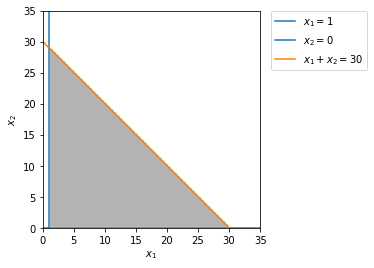

In [2]:
'''
Plot feasible region for sample linear programming problem 1.
'''
d = np.linspace(-2,70,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=1) & (y>=0) & (x+y<=30)).astype(int) , 
               extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);


# plot the lines defining the constraints
x = np.linspace(-2, 70, 2000)
y1 = (x*0) + 0
y3 = 30 - x

plt.axvline(x=1, label = r'$x_1 = 1$')
plt.plot(x, 0*np.ones_like(y1), label = r'$x_2 = 0$')
plt.plot(x, y3, label=r'$x_1 + x_2 = 30$')
plt.xlim(0,35)
plt.ylim(0,35)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.title('Feasibile region of sample optimisation problem')
plt.show()

This problem can be solved through SciPy linprog. Scipy linprog still uses interior point method, but the barriered optimsiation problem has feasible region extremely close to the original feasible region. The "exact" solution is plotted as follow.v

Text(0.5, 1.0, 'Solution of the toy example against $\\Theta$')

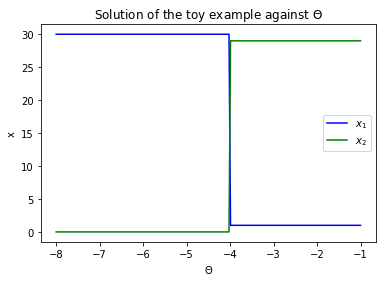

In [3]:
'''
Ground truth solution for sample linear programming problem 1.
'''
#Coefficient of objective function
c = [-1.,-4.]
#Coefficient of constraints
A = [[1.,1.]]
#Domain of solution
x0_bounds = (1, None)
x1_bounds = (0, None)
#Varying range of x
x_data =  -1*np.linspace(1,8,200)

#Solve sample LP problem 1 through scipy linprog
u_data1_real = []
u_data2_real = []
for c[0] in x_data:
    b = [[30]]
    res = linprog(c, A_ub=A, b_ub=b,A_eq= None, b_eq= None,bounds=[x0_bounds,x1_bounds])
    try:
        u_data1_real.append(res.x[0])      
        u_data2_real.append(res.x[1])
    except:
        print(x)
        break

#Plot solution
plt.plot(x_data,u_data1_real,'b',label = '$x_1$')
plt.plot(x_data,u_data2_real,'g',label = '$x_2$')
plt.legend()
# lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('$\Theta$')
plt.ylabel('x')
plt.title('Solution of the toy example against $\Theta$')

## Barrier Funtion (Interior point) Method

By combining the constraints of the sample liear programming problem, we obtain a new unconstrained linear programming problem with objective function as follows

\begin{align}
 	\begin{array}{rll}
\text{minimize}& t(- \theta x_1-4x_2) - \text{log} (30-x_1-x_2) - \text{log}(x_2) - \text{log}(x_1-1)\\
\end{array}
 \end{align}


The constraints of the original optimization problem are put into log barrier functions then added to the objective function. Since the domain of the log function is postive reals, the negated constraints has to be positive to ensure the barriered optimisation function is well defined, and this enforces the feasible region of the unconstrained (barriered) optimisation problem matches with constraints of the original problem.

What's more, lim log($0^+$) $\rightarrow$ $-\infty$, so the log term will approaches to positve infinity when the solution reaches to the boundary of the feasible region. With the sign of the log term being negative, the terms -log(*) will diverge to $\infty$ and hence gives a penalty to the minimisation problem. The barrier coefficient $t$ is introduced to increase the weight of the original objective function and balance out this penalty.

Nonetheless, the solution of barriered optimisation problem can never precisely match with the original optimisation problem. A fact of linear programming problem is that all of its solutions lie on the vertices of it polytope feasible region. By the strict positivity of the log domain, the feasible region of the barrired optimisation problem is always contained in the feasible region of the original barrier functions differed from the boundaries (hence vertices). The ground truth solutions of the original LP are not even contained in the barriered function, so the best that barrierr function method can do is to approximate the solution that converges to the ground truth solution.

Scipy package is not compatible with log barrier terms, so all following optimization problems are solved by CVXPY package.



The average time cost for determining a barriered solution is 0.005651 seconds
The average time cost for determining the gradient of a barriered solution is 0.000061 seconds


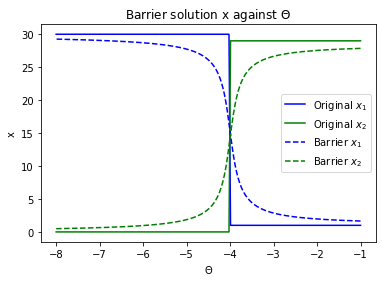

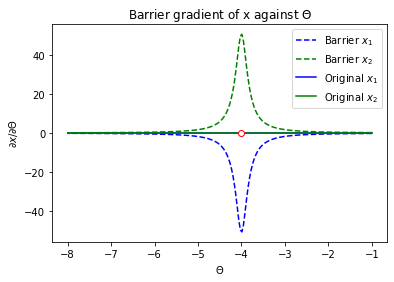

In [4]:
## Notation: u := x, x:= theta

#Objective function and its partial derivatives
def objective(t,x,u):
    return -t*x@u-np.log(u[0]-1)-np.log(30.-u[1]-u[0])-np.log(u[1])
def objective_dy(t,x,u):
    return np.array([-t*x[0]-1/(u[0]-1)+1/(30-u[0]-u[1]),-t*x[1]-1/(u[1])+1/(30-u[0]-u[1])])
def objective_dxy(t,x,u):
     return np.matrix([[t,0],\
                      [0,t]])
def objective_dyy(x,u):
    return np.matrix([[np.power(u[0]-1,-2)+np.power(30-u[0]-u[1],-2),np.power(30-u[0]-u[1],-2)],\
                      [np.power(30-u[0]-u[1],-2),np.power(30-u[0]-u[1],-2)+1/np.power(u[1],2)]])
def objective_gradient(t,x,u):
    return -np.linalg.inv(objective_dyy(x,u))*objective_dxy(t,x,u)


u = cp.Variable(2)
#Initialise input x
x = np.array([3.,-4.])
x_data = -1 * np.linspace(1,8,200)
#Barrier coefficient t
t = 0.5
#Storage vector for u_1, u_2 and their gradients w.r.t x_1
u_data0 = []
u_data1 = []
gradient0 = []
gradient1 = []

time_cost_solution = []
time_cost_gradient = []
for x[0] in x_data:
    #Barrier optimization problem
    objec = lambda u: cp.Minimize(t*x@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
    #Solving the problem with CVXPY
    prob = cp.Problem(objec(u))
    start = time.time()
    prob.solve()
    end = time.time()
    time_cost_solution.append(end-start)
    u_data0.append(u.value[0])
    u_data1.append(u.value[1])
    #Determine the gradient of the solution with the derived equation
    start = time.time()
    gradient = objective_gradient(t,x,u.value)
    end = time.time()
    time_cost_gradient.append(end-start)
    gradient0.append(gradient[0,0])
    gradient1.append(gradient[1,0])

#Plot barrier solutions
plot1 = plt.figure(1)
plt.plot(x_data,u_data1_real,'b',label = 'Original $x_1$')
plt.plot(x_data,u_data2_real,'g', label = 'Original $x_2$')
plt.plot(x_data,u_data0,'b--',label = 'Barrier $x_1$')
plt.plot(x_data,u_data1,'g--',label = 'Barrier $x_2$')
plt.xlabel('$\Theta$')
plt.ylabel('x')
plt.title('Barrier solution x against $\Theta$')
plt.legend()

#Plot barrier gradients
plot2 = plt.figure(2)
plt.plot(x_data,gradient0,'b--',label = 'Barrier $x_1$')
plt.plot(x_data,gradient1,'g--',label = 'Barrier $x_2$')
a = np.zeros_like(x_data)
plt.plot(x_data,a,'b',zorder=1,label = 'Original $x_1$')
plt.plot(x_data,a,'g',zorder=2,label = 'Original $x_2$')
plt.scatter(-4,0,color='white', edgecolors='r',zorder=3)
plt.legend()
plt.xlabel('$\Theta$')
plt.ylabel('$\partial x / \partial \Theta$')
plt.title('Barrier gradient of x against $\Theta$')




print('The average time cost for determining a barriered solution is %f seconds' %np.mean(time_cost_solution))
print('The average time cost for determining the gradient of a barriered solution is %f seconds' %np.mean(time_cost_gradient))


## Perturbed Optimizer Method

Perturbed optimiser method perturbes the input data and obtain the expected value of perturbed output. Perturbations are conducted by adding noises to input data, the noises are under standard Gumbel or Normal distribution for the ease of back propagation. In particular, noises $\epsilon Z$ should have distributions $\mu(z) \propto \exp(-\nu(z)) dz$, where the gradient of perturbed output against input is determined by  $$
\mathbb{E}[y^*(\theta + \epsilon Z)\nabla_z \nu(Z)^T/\epsilon]
$$
$\theta + \epsilon Z$ is the perturbed input, $\epsilon$ is the temperature coefficient of noise and $\nabla_z \nu(Z)$ is the derivation of $\nu$ function embraced by exponential function.

Standard Normal distribution has pdf $\frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}x^2\,\right)$. $\nabla_x\nu(x) = x$
  
Standard Gumbel distribution has pdf $\exp(-(x+\exp(-x)))$. $\nabla_x\nu(x) = 1-\exp(-x)$
  
  
Perturbation code is provided by the paper **Learning with Differentiable Perturbed Optimizers** in tensorflow enviroment. We have translated to pytorch enviroment in this notebook. In this toy LP, we only care about the partial derivative of outputs agagints $\theta$. The codes are modified to return partial derivatives instead of overall derivative.

### Perturbation Code (Translated **Learning with Differentiable Perturbed Optimizers** code from Tensorflow to Pytorch)

In [5]:
class perturbations():

    def __init__(self,func,num_samples,sigma,noise,batched):
        self.func = func
        self.num_samples = num_samples
        self.sigma = sigma
        self.noise = noise
        self.batched = batched
        
    def sample_noise_with_gradients(noise,shape):
        _GUMBEL = 'gumbel'
        _NORMAL = 'normal'
        SUPPORTED_NOISES = (_GUMBEL, _NORMAL)
        if noise not in SUPPORTED_NOISES:
            raise ValueError('{} noise is not supported. Use one of [{}]'.format(
            noise, SUPPORTED_NOISES))
        if noise == _GUMBEL:
            sampler = dist.gumbel.Gumbel(0.0, 1.0)
            samples = sampler.sample(shape)
            gradients = 1 - torch.exp(-samples)
        elif noise == _NORMAL:
            sampler = dist.normal.Normal(0.0, 1.0)
            samples = sampler.sample(shape)
            gradients = samples
        return samples, gradients

    def forward(self,input_tensor):
        original_input_shape = input_tensor.size()
        if self.batched:
            if original_input_shape[0] < 2:
                raise ValueError('Batched inputs must have at least rank two')
        else:  # Adds dummy batch dimension internally.
            input_tensor = torch.unsqueeze(input_tensor,0)
        input_shape = torch.tensor(input_tensor.size(),dtype=torch.int)  # [B, D1, ... Dk], k >= 1, Dimension of the tensor, in a sigle number.
        #input_shape = input_tensor.size()
        perturbed_input_shape = torch.cat((torch.tensor([self.num_samples]), input_shape)) #The storage space size for all perturbed sequence.

        noises = perturbations.sample_noise_with_gradients(self.noise, perturbed_input_shape) #Create noises
        additive_noise, noise_gradient = tuple([noise for noise in noises]) #Cast the noise to make the noise and input tensor operable
        perturbed_input = torch.unsqueeze(input_tensor, 0) + self.sigma * additive_noise #Add noises to the input tensor, if the expansion in dimension necessary tho?

        # [N, B, D1, ..., Dk] -> [NB, D1, ..., Dk].
        flat_batch_dim_shape = torch.cat((torch.tensor([-1]), input_shape[1:]))
        perturbed_input = torch.reshape(perturbed_input, tuple(flat_batch_dim_shape))
        # Calls user-defined function in a perturbation agnostic manner.
        perturbed_output = self.func(perturbed_input)
        # [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk].
        perturbed_input = torch.reshape(perturbed_input, tuple(perturbed_input_shape))
        # Either
        #   (Default case): [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk]
        # or
        #   (Full-reduce case) [NB] -> [N, B]
        perturbed_output_shape = torch.cat(
        (torch.tensor([self.num_samples]), torch.tensor([-1]), torch.tensor(perturbed_output.size()[1:])))
        perturbed_output = torch.reshape(perturbed_output, tuple(perturbed_output_shape))
        forward_output = torch.mean(perturbed_output,0)

        if not self.batched:
            forward_output = forward_output[0]
        self.original_input_shape = original_input_shape
        self.perturbed_input = perturbed_input
        self.noise_gradient = noise_gradient
        self.perturbed_output = perturbed_output
        return forward_output

    def backward(self,grad_output):
        if len(self.perturbed_input.size()) > len(self.perturbed_output.size()):
            self.grad_output = torch.unsqueeze(self.grad_output,-1)
            self.perturbed_output = torch.unsqueeze(self.perturbed_output,-1)
        if not self.batched:
            grad_output = torch.unsqueeze(grad_output,0)
        flatten = lambda t: torch.reshape(t, (t.size()[0], t.size()[1], -1))
        grad_output = torch.reshape(grad_output,(grad_output.size()[0],-1))
        self.perturbed_output = flatten(self.perturbed_output)
        noise_grad = flatten(self.noise_gradient)
        #Partial Derivatives
        g = torch.einsum('nbi,nbj->nij', self.perturbed_output, self.noise_gradient)
        g = torch.mean(g,0)
        g /= self.sigma
        return g

In [6]:
#Original and perturbed LPs
def Sample_LinProg1(x):
    solution = torch.zeros_like(x)
    for i in range(x.shape[0]):
        u = cp.Variable(2)
        coe = x[i].clone().detach().numpy()
        objec = lambda coe,u: cp.Minimize(coe@u)
        constraints = [u[0] >= 1,u[0]+u[1] <= 30, u>=0]
        prob = cp.Problem(objec(coe,u),constraints)
        prob.solve()
        solution[i] = torch.tensor(u.value)
    return solution

perturbed_Sample_Linprog1 = perturbations(Sample_LinProg1,2000,0.5,'gumbel',False)


The average time cost for determining one perturbed solution is 7.155544 seconds
The average time cost for determining the gradient of a barriered solution is 0.000154 seconds


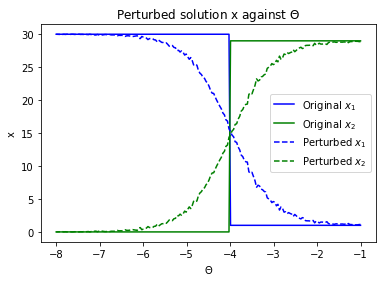

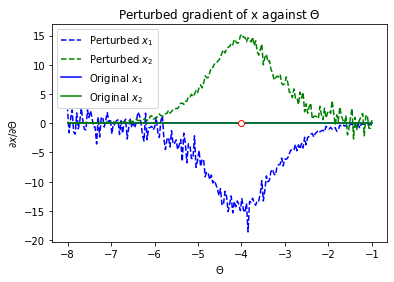

In [7]:
x = torch.tensor([-3.,-4.])
x_data = -1*np.linspace(1,8,200)
time_cost_solution = []
time_cost_gradient = []
solution = np.zeros((len(x_data),2))
gradient = np.zeros_like(solution)
dy = torch.tensor([1.,1.])
for i in range(len(x_data)):
    x[0] = x_data[i]
    x_new = x.clone().detach().requires_grad_(True)
    start = time.time()
    pert_output  = perturbed_Sample_Linprog1.forward(x_new)
    end = time.time()
    time_cost_solution.append(end-start)
    start = time.time()
    x_gradient = perturbed_Sample_Linprog1.backward(dy)
    end = time.time()
    time_cost_gradient.append(end-start)
    solution[i] = np.array(pert_output)
    gradient[i] = [x_gradient[0,0],x_gradient[1,0]]

plot1 = plt.figure(1)
plt.plot(x_data,u_data1_real,'b',label = 'Original $x_1$')
plt.plot(x_data,u_data2_real,'g', label = 'Original $x_2$')
plt.plot(x_data,solution[:,0],'b--',label = 'Perturbed $x_1$')
plt.plot(x_data,solution[:,1],'g--',label = 'Perturbed $x_2$')
plt.xlabel('$\Theta$')
plt.ylabel('x')
plt.title('Perturbed solution x against $\Theta$')
plt.legend()

plot2 = plt.figure(2)
plt.plot(x_data,gradient[:,0],'b--',label = 'Perturbed $x_1$')
plt.plot(x_data,gradient[:,1],'g--',label = 'Perturbed $x_2$')
a = np.zeros_like(x_data)
plt.plot(x_data,a,'b',zorder=1,label = 'Original $x_1$')
plt.plot(x_data,a,'g',zorder=2,label = 'Original $x_2$')
plt.scatter(-4,0,color='white', edgecolors='r',zorder=3)
plt.legend()
plt.xlabel('$\Theta$')
plt.ylabel('$\partial x / \partial \Theta$')
plt.title('Perturbed gradient of x against $\Theta$')
print("The average time cost for determining one perturbed solution is %f seconds" %np.mean(time_cost_solution))
print('The average time cost for determining the gradient of a barriered solution is %f seconds' %np.mean(time_cost_gradient))